In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib as mpl
%matplotlib inline
%config InlineBackend.figure_format = 'svg'

import pprint

import scipy.stats as stats

from sklearn.linear_model import LinearRegression, RidgeCV, LassoCV, ElasticNetCV
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score
from sklearn.model_selection import train_test_split



In [2]:
from sklearn import __version__ as skvers
skvers

'0.20.2'

## Define some useful feature engineering functions

Tweaking the train and test sets causes all sorts of warnings about 
mucking with copies of slices of a dataframe, so just set it on the 
whole dataset and we'll reslice at the end of feature engineering

In [3]:
def create_nan_category(column, fill):
    """create_nan_category(column)
           adds column_nan with one-hot where the nans were
           fills nans in column with fill
       returns df"""
    
    nan_col = column + "_nan"
    
    query = column + " != " + column
    nullidx = data.query(query).index
    data.loc[nullidx, column] = fill
    
    data[nan_col] = 0.0
    data.loc[nullidx, nan_col] = 1.0
    

def log_transform(column):
    """log_transform(column)
        creates the column column_log"""
    new_col = column + "_log"
    data[new_col] = np.log(data[column])
    
   
def log1p_transform(column):
    """log_transform(df, column)
       creates the column column_log"""
    new_col = column + "_log1p"
    data[new_col] = np.log1p(data[column])


def square_transform(column):
    """square_transform(df, column)
       creates the column column_squared"""
    new_col = column + "_squared"
    data[new_col] = np.square(data[column])


def QQ_plot(obs):
    """QQ-plot of obs"""
    z = (obs-np.mean(obs))/np.std(obs)
    stats.probplot(z, dist="norm", plot=plt)
    plt.title("Normal Q-Q plot")
    plt.show()

## Read in the data set

In [4]:
data = pd.read_pickle("../data/MERGED2016_17_select.pck")

In [5]:
data.shape

(1604, 31)

In [6]:
data.columns

Index(['GRAD_DEBT_MDN', 'MAIN', 'BACH_ONLY', 'PUBLIC', 'ADM_RATE', 'SAT_AVG',
       'UGDS', 'UGDS_WHITE', 'UGDS_BLACK', 'UGDS_HISP', 'UGDS_ASIAN',
       'UGDS_AIAN', 'UGDS_NHPI', 'UGDS_2MOR', 'UGDS_NRA', 'UGDS_UNKN',
       'COSTT4_A', 'TUITIONFEE_IN', 'TUITIONFEE_OUT', 'TUITFTE', 'INEXPFTE',
       'AVGFACSAL', 'PFTFAC', 'PCTPELL', 'PFTFTUG1_EF', 'OPENADMIT', 'PRIVATE',
       'COMPADMIT', 'INSTNM', 'CITY', 'STABBR'],
      dtype='object')

### Train_test_split



In [7]:
y =  data['GRAD_DEBT_MDN']
X = data.drop(columns='GRAD_DEBT_MDN')

X_train, X_test, y_train, y_test = train_test_split(
                    X, y, test_size=0.20, random_state=42)

In [8]:
X_train.shape

(1283, 30)

In [9]:
X_test.shape

(321, 30)

In [10]:
y_train.shape

(1283,)

In [11]:
y_test.shape

(321,)

In [12]:
X_train_public = X_train.query("PUBLIC == 1")
X_train_private = X_train.query("PUBLIC == 0")

## Feature engineering of predictors

The predictors are sorted into categorical and numerical, since only the numerical ones will be scaled

In [13]:
predictors = [] # Add them to the list as we clean things up
categorical_predictors = [] # keep these separate as they are not scaled 

### Numerical columns

In [14]:
# Too much missing data to fudge -- 
# Add a new categorical column to mean "Admissions data not
# published"
create_nan_category('ADM_RATE', 0)

In [15]:
categorical_predictors += [ 'ADM_RATE_nan']

#### SAT score

In [16]:
# plotting logs, squares didn't make a difference
# I guess this is normal enough for now

create_nan_category('SAT_AVG', 0)
predictors += [ 'SAT_AVG' ]

#### Number of undergrads

In [17]:
predictors += [ 'UGDS' ] 

#### Percent white undergrads 

In [18]:
square_transform('UGDS_WHITE')
predictors += [ 'UGDS_WHITE_squared' ]

#### Cost of attendance 

Lots of mostly collinear cost features

In [19]:
money_feats = ['COSTT4_A', 
               'TUITFTE',
               'TUITIONFEE_IN', 
               'TUITIONFEE_OUT',
              ]

In [20]:
X_train[money_feats].corr()

COSTT4_A   TUITFTE  TUITIONFEE_IN  TUITIONFEE_OUT
COSTT4_A        1.000000  0.816415       0.981569        0.911448
TUITFTE         0.816415  1.000000       0.804368        0.781857
TUITIONFEE_IN   0.981569  0.804368       1.000000        0.899851
TUITIONFEE_OUT  0.911448  0.781857       0.899851        1.000000

In [21]:
data['COST'] = data.eval(
    'COSTT4_A + TUITFTE + TUITIONFEE_IN'
)

In [22]:
log_transform('COST')

In [23]:
predictors += [ 'COST_log' ] 

data['COST_log_P'] = data['COST_log'] * data['PUBLIC']

predictors += [ 'COST_log_P' ]

#### Average faculty salary

In [24]:
X_train.AVGFACSAL.count()

1281

In [25]:
X_test.AVGFACSAL.count()

321

In [26]:
# Missing 2 observations from train set and none from test set

idx = data.query('AVGFACSAL != AVGFACSAL').index
data.loc[idx, 'AVGFACSAL'] = data.AVGFACSAL.median()

predictors += [ 'AVGFACSAL' ]

####  Percent part time faculty

In [27]:
idx = X_train_public.query('PFTFAC != PFTFAC').index
if len(idx):
    data.loc[idx, 'PFTFAC'] = X_train_public.PFTFAC.median()

idx = X_train_private.query('PFTFAC != PFTFAC').index
if len(idx):
    data.loc[idx, 'PFTFAC'] = X_train_private.PFTFAC.median()

In [28]:
predictors += [ 'PFTFAC' ]

#### Instructional expenditure per full time equivalent

In [29]:
predictors += [ "INEXPFTE" ]

#### Percent of students receiving pell grants

In [30]:
predictors += [ 'PCTPELL' ]

#### Share of entering undergrads who are first-time, full-time, degree-seeking

In [31]:
predictors += ['PFTFTUG1_EF']

In [32]:
data.loc[:, ['GRAD_DEBT_MDN'] + predictors + categories ].corr()

NameError: name 'categories' is not defined

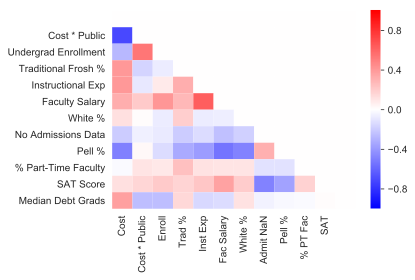

In [33]:
ordering = [ 'COST_log', 'COST_log_P', 'UGDS', 'PFTFTUG1_EF', 
           'INEXPFTE', 'AVGFACSAL', 'UGDS_WHITE_squared', 
           'ADM_RATE_nan', 'PCTPELL', 'PFTFAC', 'SAT_AVG', 'GRAD_DEBT_MDN']

yticklabels = [
               '', 
               'Cost * Public',
                'Undergrad Enrollment',
               'Traditional Frosh %', 
               'Instructional Exp', 
               'Faculty Salary', 
               'White %', 
               'No Admissions Data', 
               'Pell %',
               '% Part-Time Faculty', 
               'SAT Score',
               'Median Debt Grads' 
              ]

xticklabels = [
               'Cost', 
               'Cost * Public',
                'Enroll', 
               'Trad %', 
               'Inst Exp', 
               'Fac Salary' ,
               'White %', 
               'Admit NaN', 
               'Pell %',
               '% PT Fac', 
               'SAT',
                ''
              ]

sns.set_style('white')

corr = data.loc[:, ordering ].corr()
dim = len(ordering)
for i in range(dim):
    for j in range(dim):
        if i <= j:
            corr.iloc[i,j] = 0


sns.heatmap(corr, cmap='bwr', vmin=-1, vmax=1, xticklabels=xticklabels, yticklabels=yticklabels)

plt.tight_layout()
plt.savefig('../plots/heatmap.svg')


## Setting up modeling

In [34]:
predictors = [ 'SAT_AVG', 'UGDS', 'UGDS_WHITE_squared', 'COST_log', 'COST_log_P', 
             'AVGFACSAL', 'PFTFAC', 'INEXPFTE', 'PCTPELL', 'PFTFTUG1_EF' ] 
categories = [ 'ADM_RATE_nan']

In [35]:
X_train  = data.loc[X_train.index,predictors]
X_test   = data.loc[X_test.index,predictors]

In [36]:
std = StandardScaler()
std.fit(X_train.values)
X_train_tr = std.transform(X_train.values)
X_test_tr = std.transform(X_test.values)

# add the categorical values
X_tr_df = pd.DataFrame(data=X_train_tr, index=X_train.index, columns=predictors)
X_test_df = pd.DataFrame(data=X_test_tr, index=X_test.index, columns=predictors)
for c in categories:
    X_tr_df[c] = data.loc[X_train.index, c].astype(float)
    X_test_df[c] = data.loc[X_test.index, c].astype(float)

ridge_lr = RidgeCV(cv=10, alphas=np.arange(3.0, 6.0, 0.1))
lasso_lr = LassoCV(cv=10)

In [37]:
for lr,name in zip([ridge_lr, lasso_lr], ["Ridge", "Lasso"]):
    lr.fit(X_tr_df.values, y_train)
    yhat = lr.predict(X_test_df.values)
    r2 = r2_score(y_test, yhat)
    print(name, "alpha=", lr.alpha_, "intercept=", lr.intercept_, "r2=", r2)
    pprint.pprint(pd.DataFrame(index=X_test_df.columns, data=lr.coef_))
    print("")

Ridge alpha= 4.800000000000002 intercept= 23013.818300253337 r2= 0.3235224090760275
                              0
SAT_AVG              447.863909
UGDS                -600.474862
UGDS_WHITE_squared   255.114715
COST_log            5274.398080
COST_log_P          2672.852071
AVGFACSAL          -1197.541757
PFTFAC               100.029162
INEXPFTE           -1535.982705
PCTPELL             1356.890885
PFTFTUG1_EF          203.237189
ADM_RATE_nan        1077.877762

Lasso alpha= 2.2676728673617923 intercept= 23008.78699763949 r2= 0.32408002739259434
                              0
SAT_AVG              451.302372
UGDS                -600.732285
UGDS_WHITE_squared   255.349916
COST_log            5411.075544
COST_log_P          2783.763165
AVGFACSAL          -1236.880433
PFTFAC               101.551353
INEXPFTE           -1539.040372
PCTPELL             1393.466039
PFTFTUG1_EF          192.954551
ADM_RATE_nan        1150.407663



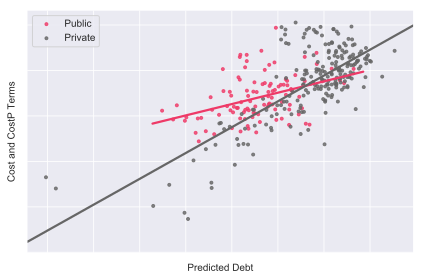

In [38]:
lr = lasso_lr
coeff_frame = pd.DataFrame(index=X_test_df.columns, data=lr.coef_)

cost_component = X_test_df.COST_log  * coeff_frame.loc['COST_log', 0]  + X_test_df.COST_log_P * coeff_frame.loc['COST_log_P', 0] + lr.intercept_
fac_ins        = X_test_df.AVGFACSAL * coeff_frame.loc['AVGFACSAL', 0] + X_test_df.INEXPFTE   * coeff_frame.loc['INEXPFTE', 0]   + lr.intercept_

public = data.loc[X_test_df.index,:].query('PUBLIC == 1').index
private = data.loc[X_test_df.index,:].query('PUBLIC != 1').index

yhat = pd.Series(lr.predict(X_test_df.values), index=X_test_df.index)
    
sns.set_style('darkgrid')
sns.regplot(yhat[public],  cost_component[public],  marker=".", ci=None, color=(238/255, 57/255, 103/255), label="Public")
sns.regplot(yhat[private], cost_component[private], marker=".", ci=None, color=(0.4, 0.4, 0.4), label="Private")
plt.xlabel("Predicted Debt")
plt.ylabel("Cost and CostP Terms")
ax = plt.gca()
ax.get_xaxis().set_ticklabels([])
ax.get_yaxis().set_ticklabels([])
ax.spines['top'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['right'].set_visible(False)

plt.legend()
plt.tight_layout()
plt.savefig("../plots/slopes.svg")
plt.show()

In [39]:
lr = ridge_lr

In [40]:
yhat = lr.predict(X_tr_df.values)

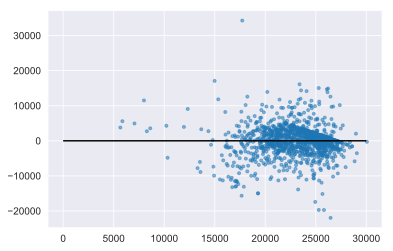

In [41]:
plt.scatter(yhat, y_train - yhat, marker=".", alpha=0.5) 
plt.hlines(0, 0, 30000)

/Users/jlc/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


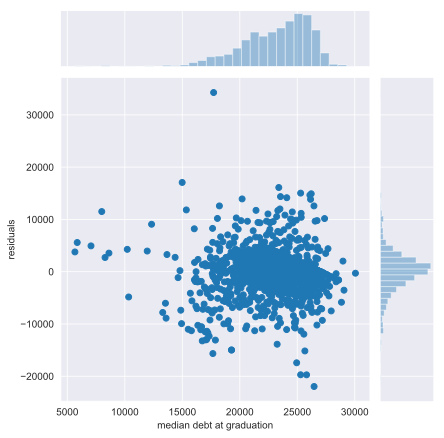

In [42]:
sns.jointplot(x=yhat, y=(y_train - yhat)).set_axis_labels("median debt at graduation", "residuals")

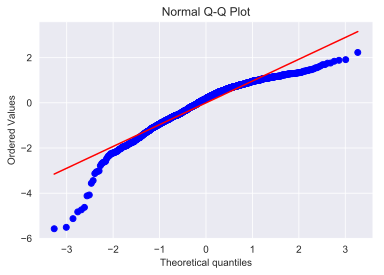

In [43]:
obs = yhat
z = (obs-np.mean(obs))/np.std(obs)
stats.probplot(z, dist="norm", plot=plt)
fig = plt.get_current_fig_manager()
plt.title("Normal Q-Q Plot")
plt.show()

23008.78699763949


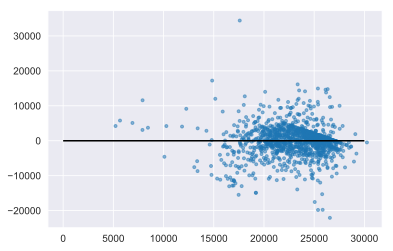

In [44]:
lr = lasso_lr
print(lr.intercept_)
yhat = lr.predict(X_tr_df.values)
plt.scatter(yhat, y_train - yhat, 
            marker = ".", alpha=0.5)
plt.hlines(0,0,30000)

/Users/jlc/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


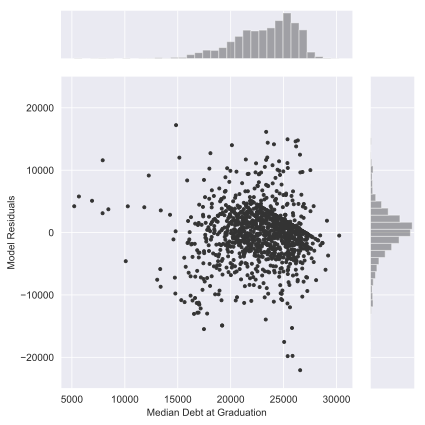

In [45]:
sns.set_style('darkgrid')
sns.jointplot(x=yhat, y=(y_train-yhat), marker=".", color=(.2,.2,.2)).set_axis_labels(
    "Median Debt at Graduation", "Model Residuals")
plt.ylim((-25000,25000))
plt.tight_layout()
plt.savefig("../plots/residuals.svg")

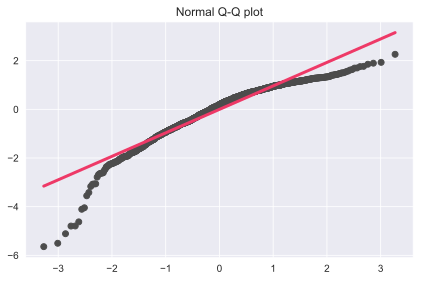

In [46]:
obs = yhat
z = (obs-np.mean(obs))/np.std(obs)
dots, fitline = stats.probplot(z, dist="norm")
plt.scatter(dots[0], dots[1], color=(.3,.3,.3))
y = [ x*fitline[0] + fitline[1] for x in dots[0] ]
plt.plot(dots[0], y, color=(238/255, 57/255, 103/255), linewidth=3)
plt.title("Normal Q-Q plot")
plt.tight_layout()
plt.savefig("../plots/QQ.svg")
plt.show()

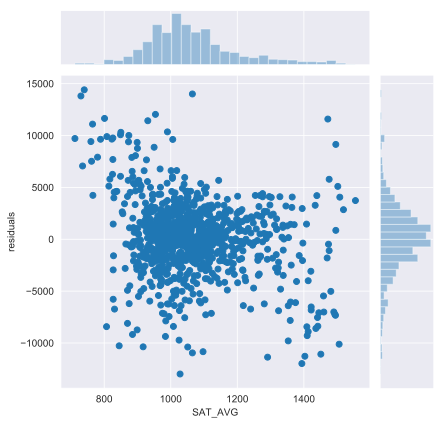

In [47]:
# SAT AVG plot clean
sns.set_style('darkgrid')

sat_idx = X_train.query('SAT_AVG > 100').index

sat_x = X_train.loc[sat_idx, 'SAT_AVG']
sat_y = (y_train - yhat).loc[sat_idx,] 

sns.jointplot(x=sat_x, y=sat_y).set_axis_labels('SAT_AVG', 'residuals')

SAT_AVG


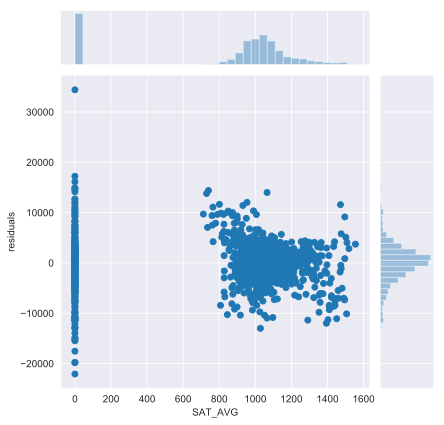

UGDS


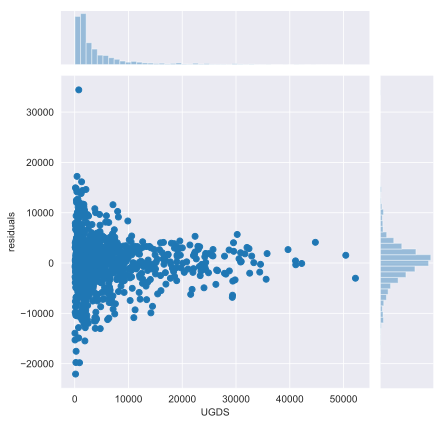

UGDS_WHITE_squared


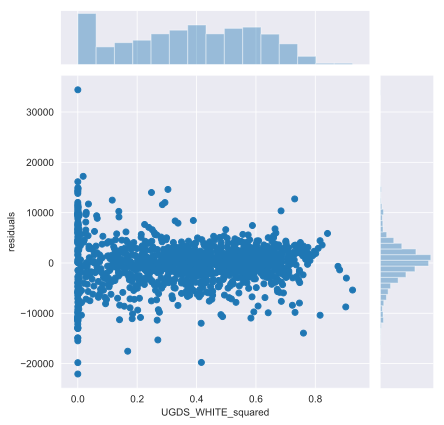

COST_log


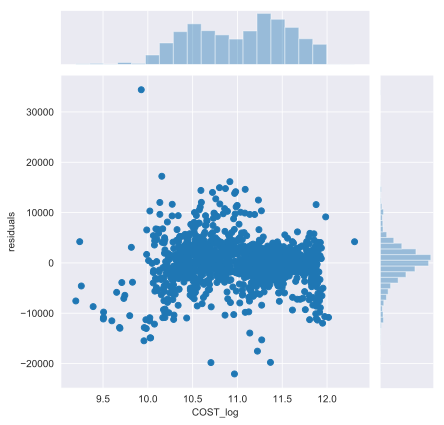

COST_log_P


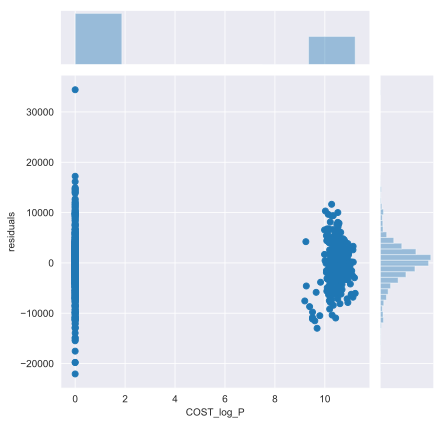

AVGFACSAL


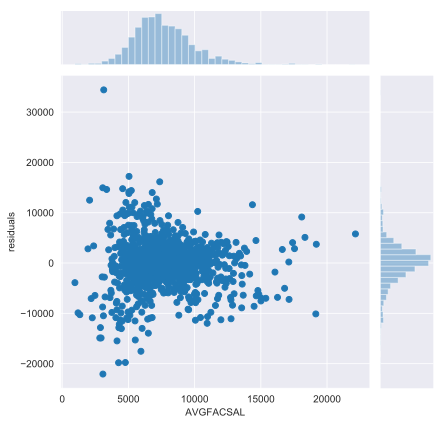

PFTFAC


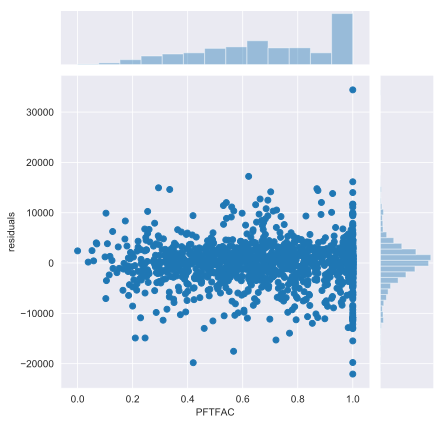

INEXPFTE


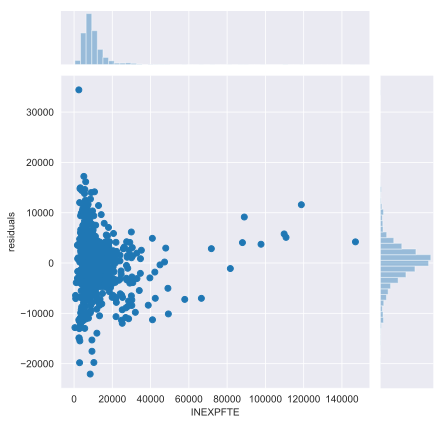

PCTPELL


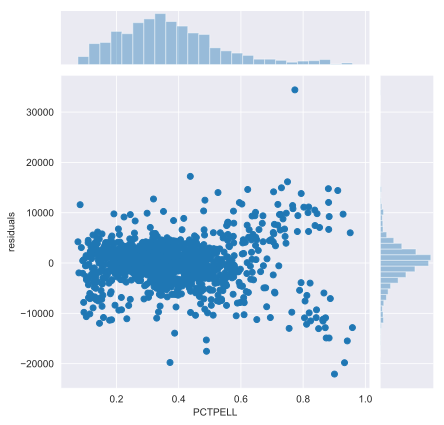

PFTFTUG1_EF


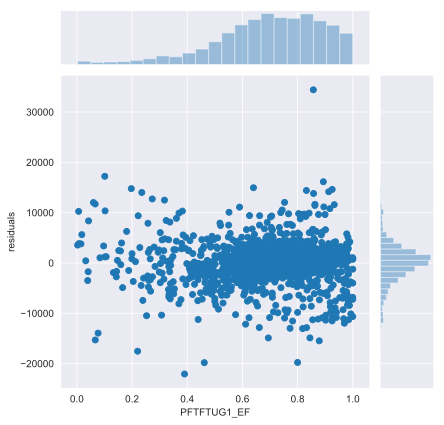

In [48]:
for c in predictors:
    print(c)
    if True:
        sns.jointplot(x=X_train[c], y=(y_train - yhat)).set_axis_labels(c, "residuals")
    else:
        plt.scatter(X_train[c], y_train - yhat, marker=".", alpha=0.5) 
        plt.hlines(0,0,X_train[c].max())
    plt.show()


In [49]:
resid = y_train - yhat
resid_public = resid[X_train_public.index]
resid_private = resid[X_train_private.index]


X_train_pub2plot = data.loc[X_train.index,:].query('PUBLIC == 1')
X_train_priv2plot = data.loc[X_train.index,:].query('PUBLIC == 0')


SAT_AVG


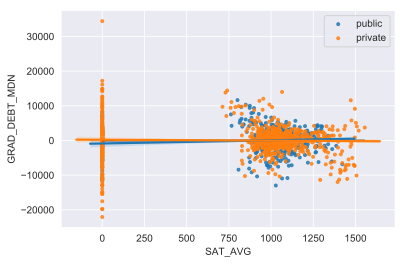

UGDS


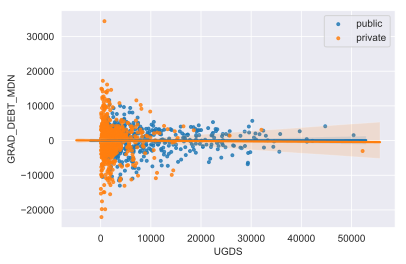

UGDS_WHITE_squared


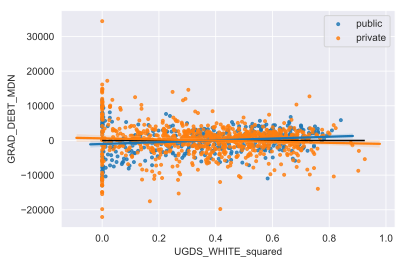

COST_log


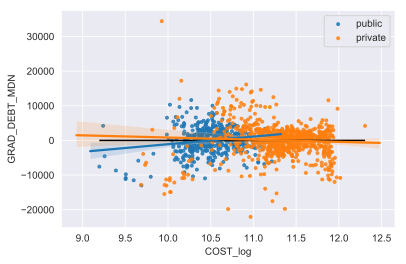

COST_log_P


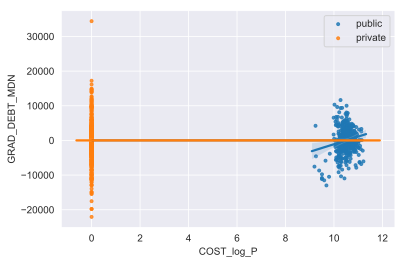

AVGFACSAL


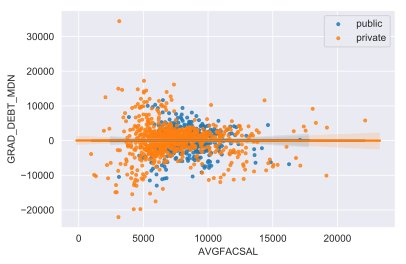

PFTFAC


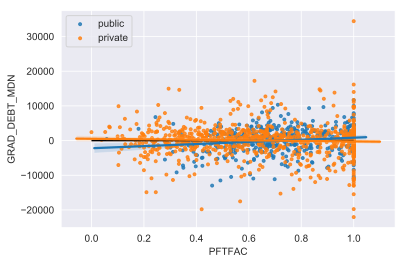

INEXPFTE


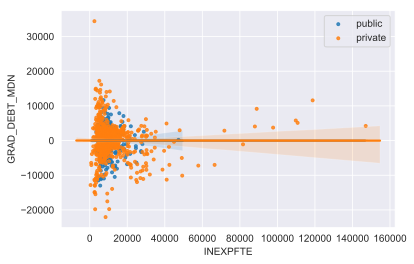

PCTPELL


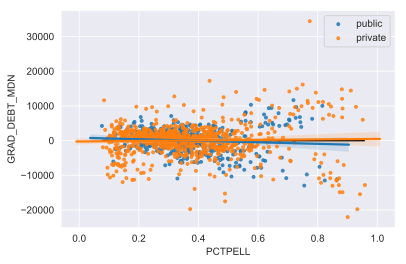

PFTFTUG1_EF


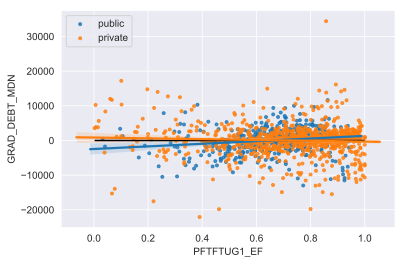

In [50]:
for c in predictors:
    print(c)
    if True:
        sns.regplot(X_train_pub2plot.loc[:, c], resid_public, marker='.', label='public')
        sns.regplot(X_train_priv2plot.loc[:, c], resid_private, marker='.', label='private')
    else:
        plt.scatter(X_train_pub2plot.loc[:, c], resid_public, marker='.', alpha=0.5, label='public')
        plt.scatter(X_train_priv2plot.loc[:, c], resid_private, marker='.', alpha=0.5, label='private')
        
    plt.hlines(0,X_train[c].min(),X_train[c].max())
    plt.legend()
    plt.show()